# Last homework: designing a microscope using machine learning

For the final homework assignment, we will design a microscope using machine learning! In order to do this, we will combine elements of HW3 (CNNs) and HW4 (microscope simulator) into a single end-to-end architecture. In particular, we will convert the MNIST digits into phase/amplitude objects and process them through a microscope simulator as we did in HW4, add noise, and then feed the output into a CNN to classify the digit. In addition to optimizing the CNN parameters, we will also be simultaneously optimizing the input illumination incident on the sample as well as the aperture plane.

Below, we will walk you through the steps of implementing this joint architecture, leaving some portions blank for you to implement. We will first instruct you to use specific values that we have tested and are known to give reasonable results. Later on, you will revisit the code and explore different hyperparameter settings.

## 1. import stuff and load MNIST
As always, we split the dataset into training and testing. This code was copied from the jupyter notebook from TA session 5 and slightly modified.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## 2. convert the MNIST images into microscope samples
Convert the MNIST images into phase-only objects. To do this, normalize the MNIST digits to be between 0 and 1, and make the object 1 wavelength thick (we may come back later to adjust the sample thickness).

In [2]:
wavelength = .5
def convert_MNIST(X, optical_thickness):
    X = X/X.max()
    X = X * np.exp(1j*X*np.random.uniform(0,1))
    return X

X_train = convert_MNIST(X_train, 1)
X_test = convert_MNIST(X_test, 1)
X_train = X_train.reshape([X_train.shape[0],28,28,1])
X_test = X_test.reshape([X_test.shape[0],28,28,1])

## 3. create input pipeline for generating training/testing batches
For your convenience, this was also copied from TA session 5 (and slightly modified). You don't need to do anything here but run this block:

In [3]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28, 1], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

## 4. create complex-valued trainable illumination
The input field will be a 28x28 complex-valued field that interacts with the sample. In practice, this input field might be obtained by using a spatial light modulator (SLM), an optical element that can be programmed to display an arbitrary phase and/or amplitude pattern pixel by pixel. We will use a phase-only SLM, so that the variable to optimize is a 28x28 array of phases (from 0 to 2pi).

In [4]:
# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = True  

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
input_illumination_phase = tf.Variable(tf.ones(shape=(28,28,1))*tf.random_uniform(shape=(1,1)), 
                                       dtype=tf.float32, trainable=train_illumination)

# using that input phase, create the input field:
input_illumination = tf.complex(tf.zeros(shape=(28,28,1)), 
                                input_illumination_phase)

## 5. generate the emerging field from the sample
Given a stack of input images, X_batch (generated above), create a tensorflow array representing the emerging field from the sample. This is the same as what you did in HW4, except in HW4 you had a tilted plane wave.

In [5]:
# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = input_illumination*X_batch

## 6. propagate the emerging field to the aperture plane
As in HW4, propagate the field emerging from the sample to the aperture plane (also known as the Fourier plane). Remember to use tensorflow operations!

In [6]:
def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2] + 1
    s2 = s[-1] + 1
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

aperture_plane = tf.fft2d(emerging_field)
aperture_plane = tf_fftshift2(aperture_plane)

## 7. create complex-valued trainable aperture function
In HW4, we modeled a circular aperture in the aperture plane of our microscope. Please do the same here. For now, in whatever coordinate system you have established, please try to ensure that the radius extends across 8 pixels of the 28 pixels that will define the k-space matrix for this MNIST dataset along one dimension. We may come back later to adjust this radius.

In addition, for extra flexibility, let's add an SLM in the aperture plane. Assume the SLM is a phase-only SLM (only values from 0 to 2pi are allowed).

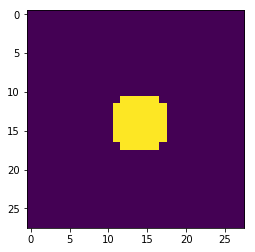

In [7]:
# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = True

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:
lens_apert = 8/28

#Define lens transfer function as matrix with 1's within desired radius, 0's outside
def make_lens(lens_apert, size):
    lens = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            dist = np.sqrt((i-size/2)**2+(j-size/2)**2)
            if dist < lens_apert/2*size:
                lens[i,j] = 1
    return lens

circ_aper = make_lens(lens_apert, 28)
plt.imshow(circ_aper)
plt.show()
circ_aper = circ_aper.astype(np.float32)
circ_aper = circ_aper.reshape([28,28,1])

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.Variable(tf.ones(shape=(28,28,1))*tf.random_uniform(shape=(1,1)), 
                             dtype=tf.float32, trainable=train_aperture)

# write the full aperture function, combining the above two components:
aperture = tf.complex(circ_aper, aperture_phase)

# filter the field that you propagated:
aperture_plane_filtered = aperture*aperture_plane

## 8. propagate to the image plane
Next, we propagate the field to the image plane and take the magnitude squared (since we can only measure intensity). Add some Gaussian noise, since real measurements are noisy. Use tf.random_normal and for now use a stddev of .05. 

In [8]:
# propagate the field from the aperture plane to the image plane and convert it to intensity:
def tf_ifftshift2(A):
    # 2D ifftshift
    # apply ifftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1 // 2:, :], A[..., :s1 // 2, :]], axis=-2)
    A = tf.concat([A[..., :, s2 // 2:], A[..., :, :s2 // 2]], axis=-1)
    return A

image = tf_ifftshift2(aperture_plane_filtered)
image = tf.ifft2d(image)
image = abs(image)**2

# add noise:
image += tf.random_normal(shape=(28,28,1), stddev=0.05)

## 9. process the simulated image through a CNN
Use your favorite CNN architecture that classifies MNIST or come up with a new one. You may copy a network architecture from a previous TA or class session.

In [9]:
net_input_layer = tf.reshape(image, [-1, 28, 28, 1])  # add a channels dimension

from tensorflow.layers import conv2d, max_pooling2d, flatten, dense
# define your CNN here
img = net_input_layer

net = conv2d(img, filters=64, kernel_size=(3,3), padding='same', 
            activation='relu')
net = max_pooling2d(net, padding='same', pool_size=2, strides=2)

net = conv2d(net, filters=128, kernel_size=(3,3), padding='same', 
            activation='relu')
net = max_pooling2d(net, padding='same', pool_size=2, strides=2)

# net = conv2d(net, filters=256, kernel_size=(3,3), padding='same', 
#             activation='relu')
# net = max_pooling2d(net, padding='same', pool_size=2, strides=2)
# net = conv2d(net, filters=256, kernel_size=(3,3), padding='same', 
#             activation='relu')
# net = max_pooling2d(net, padding='same', pool_size=2, strides=2)

# net = conv2d(net, filters=512, kernel_size=(3,3), padding='same', 
#             activation='relu')
# net = max_pooling2d(net, padding='same', pool_size=2, strides=2)
# net = conv2d(net, filters=512, kernel_size=(3,3), padding='same', 
#             activation='relu')
# net = max_pooling2d(net, padding='same', pool_size=2, strides=2)

net = flatten(net)
net = dense(net, units=512, activation='relu')
net = dense(net, units=10)

# model = Model(inputs=img, outputs=d2)
# model.summary()

logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## 10. train!

In [10]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

Let's first look at a few simulated noisy microscope images.

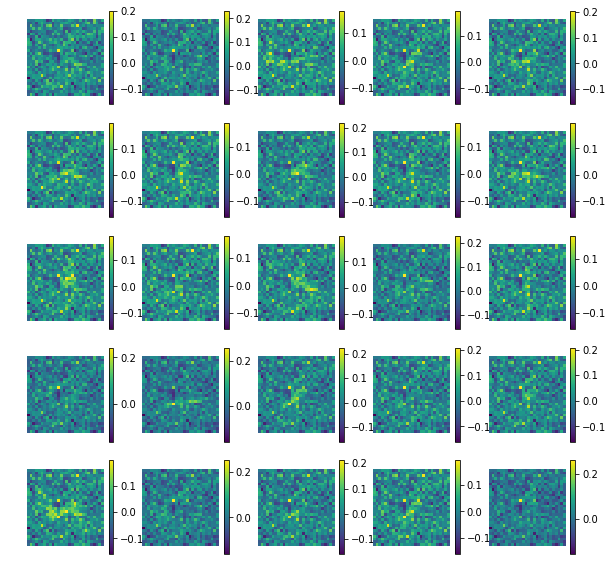

In [11]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i].reshape([28,28]))
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

Write your train loop here. Feel free to monitor loss and/or aperture/illumination phases during training. When we tested this, the optimizer had a slow start, and we had to run for several 1000 batches. Pick a value for the number of iterations and keep it fixed.

In [12]:
for i in range(1000):
    _, l = sess.run([train_op, loss])
    if i % 100 == 0:
        print('Loss at ' + str(i) + 'th iteration: ' + str(l))
#         print(input_illumination_phase.eval())

Loss at 0th iteration: 2.3038223
Loss at 100th iteration: 2.295003
Loss at 200th iteration: 2.2809107
Loss at 300th iteration: 2.1800303
Loss at 400th iteration: 1.2639353
Loss at 500th iteration: 1.084795
Loss at 600th iteration: 1.0179489
Loss at 700th iteration: 0.2875163
Loss at 800th iteration: 0.34415096
Loss at 900th iteration: 0.3166909


Let's first look at a few simulated noisy microscope images AFTER training. Do the images look more recognizable?

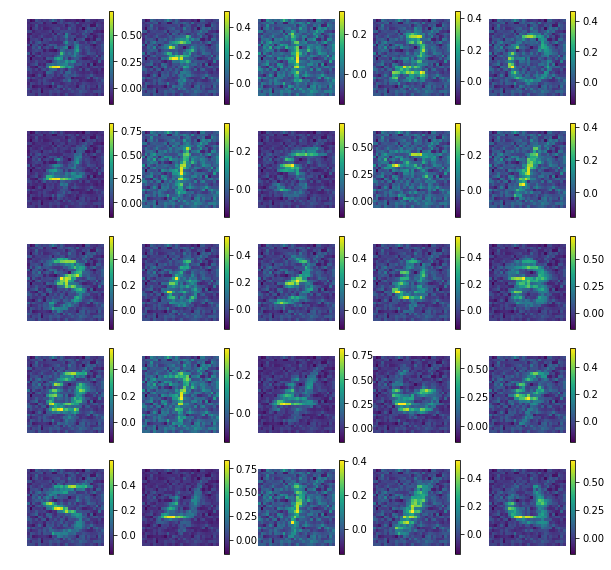

In [13]:
# plot examples 
plot_examples(image.eval())

### It is clear that the images are much more improved and recognizable than the ones before training

Pass through the test set.

In [14]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})

# pass through test set:

def run_acc(sess):
    correct = 0
    total = 0
    for i in range(100):
        prediction, truth = sess.run([logits, y_batch])
        correct += np.sum(prediction.argmax(1)==truth)
        total += len(truth)
    acc = correct/total
    print('Test accuracy: ' + str(acc))
    return acc

accu = run_acc(sess)

sess.close()

Test accuracy: 0.8859375


Ok, now you've run a machine learning model with a physical layer! You did it! Please respond to the following questions. Note that this is a pretty open-ended analysis, and everyone may achieve different results depending on the selected parameters -- as long as you get question 1 to work, it's okay if the other questions give uninteresting results!

1. First, using the default hyperparameters based on the instructions and code we provided, please run the training under the following conditions:
    1. Allowing optimization of aperture phase and illumination phase.
    2. Allowing optimization of neither aperture phase nor illumination phase (this is a control experiment, because only the CNN is trained).
    3. Allowing optimization of only the aperture phase.
    4. Allowing optimization of only the illumination phase.
    
    For these 4 conditions, report the final test classification accuracies as well as the optimized aperture phase and/or illumination phase. Provide a brief analysis of the results (hint: if you don't see a difference between at least two of the above conditions, something probably went wrong!).
   
2. If you got question 1 to work, good work! Next, let's try changing some of the hyperparameters above. For each of the following questions, rerun the analysis from question 1 (under conditions of 1A and 1B). Ideally, we want to find situations where the CNN with the physical layer (the microscope simulating layers) outperforms the CNN-only network. Comment on the gap in performance between the physically-optimized and non-physically-optimized cases. Also comment on the optimized aperture and/or illumination phase.

    * For question 1, you initialized with a constant phase. Next, try to initialize the optimization with random-valued aperture phase and illumination phase.
    * Try changing the diameter of the aperture to two other values. For example, half and double the original diameter used above.

In [15]:
def get_accuracy(train_illumination, train_aperture, constant_phase=True, lens_apert = 8/28):
    # this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
    X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28, 1], name='input_image')
    y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
    batch_size = 32

    # create a tf dataset, from which we can generate batches
    dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
    dataset = dataset.batch(batch_size).repeat(None)
    batch_generator = dataset.make_initializable_iterator()
    X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated
    
    # create the variable corresponding to the input illumination phase; initialize to a constant phase:
    # (remember this is a weight variable that you will optimize!)
    if constant_phase:
        input_illumination_phase = tf.Variable(tf.ones(shape=(28,28,1))*tf.random_uniform(shape=(1,1)), 
                                               dtype=tf.float32, trainable=train_illumination)
    else:
        input_illumination_phase = tf.Variable(tf.random_uniform(shape=(28,28,1)), 
                                               dtype=tf.float32, trainable=train_illumination)

    # using that input phase, create the input field:
    input_illumination = tf.complex(tf.zeros(shape=(28,28,1)), 
                                    input_illumination_phase)
    
    # be sure to match the shapes/dimensions to enable broadcasting:
    emerging_field = input_illumination*X_batch
    
    aperture_plane = tf.fft2d(emerging_field)
    aperture_plane = tf_fftshift2(aperture_plane)
    
    circ_aper = make_lens(lens_apert, 28)
    circ_aper = circ_aper.astype(np.float32)
    circ_aper = circ_aper.reshape([28,28,1])

    # create the variable corresponding to the aperture phase; initialize to a constant phase:
    # (remember this is a weight variable that you will optimize!)
    if constant_phase:
        aperture_phase = tf.Variable(tf.ones(shape=(28,28,1))*tf.random_uniform(shape=(1,1)), 
                                     dtype=tf.float32, trainable=train_aperture)
    else:
        aperture_phase = tf.Variable(tf.random_uniform(shape=(28,28,1)), 
                                     dtype=tf.float32, trainable=train_aperture)

    # write the full aperture function, combining the above two components:
    aperture = tf.complex(circ_aper, aperture_phase)

    # filter the field that you propagated:
    aperture_plane_filtered = aperture*aperture_plane
    
    image = tf_ifftshift2(aperture_plane_filtered)
    image = tf.ifft2d(image)
    image = abs(image)**2

    # add noise:
    image += tf.random_normal(shape=(28,28,1), stddev=0.05)
    
    net_input_layer = tf.reshape(image, [-1, 28, 28, 1])  # add a channels dimension

    img = net_input_layer

    net = conv2d(img, filters=64, kernel_size=(3,3), padding='same', 
                activation='relu')
    net = max_pooling2d(net, padding='same', pool_size=2, strides=2)

    net = conv2d(net, filters=128, kernel_size=(3,3), padding='same', 
                activation='relu')
    net = max_pooling2d(net, padding='same', pool_size=2, strides=2)

    net = flatten(net)
    net = dense(net, units=512, activation='relu')
    net = dense(net, units=10)

    logits = net

    loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

    # boilerplate code:
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})
    
    for i in range(1000):
        _, l = sess.run([train_op, loss])
        if i % 100 == 0:
            print('Loss at ' + str(i) + 'th iteration: ' + str(l))
            
    sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})
    
    correct = 0
    total = 0
    for i in range(100):
        prediction, truth = sess.run([logits, y_batch])
        correct += np.sum(prediction.argmax(1)==truth)
        total += len(truth)
    acc = correct/total
    print('Test accuracy: ' + str(acc))
    
    sess.close()
    
    return acc

# 1A

In [16]:
# Result of 1A is basically result of the constructed part above, no re-train needed

both = accu
print('Test accuracy: ' + str(both))

Test accuracy: 0.8859375


# 1B

In [17]:
train_illumination = False
train_aperture = False

neither = get_accuracy(train_illumination, train_aperture)

Loss at 0th iteration: 2.306043
Loss at 100th iteration: 1.4420401
Loss at 200th iteration: 0.7347021
Loss at 300th iteration: 0.68389356
Loss at 400th iteration: 0.8862032
Loss at 500th iteration: 1.3637819
Loss at 600th iteration: 0.9614602
Loss at 700th iteration: 0.6133373
Loss at 800th iteration: 0.6398723
Loss at 900th iteration: 0.40706378
Test accuracy: 0.756875


# 1C

In [38]:
train_illumination = True
train_aperture = False

illu_only = get_accuracy(train_illumination, train_aperture)

Loss at 0th iteration: 2.304527
Loss at 100th iteration: 2.3002234
Loss at 200th iteration: 2.2975116
Loss at 300th iteration: 2.2856426
Loss at 400th iteration: 2.2987938
Loss at 500th iteration: 2.1243181
Loss at 600th iteration: 1.5462438
Loss at 700th iteration: 1.2084059
Loss at 800th iteration: 0.8127471
Loss at 900th iteration: 0.442411
Test accuracy: 0.7153125


# 1D

In [19]:
train_illumination = False
train_aperture = True

aper_only = get_accuracy(train_illumination, train_aperture)

Loss at 0th iteration: 2.3015814
Loss at 100th iteration: 1.56755
Loss at 200th iteration: 0.9430834
Loss at 300th iteration: 0.83659494
Loss at 400th iteration: 1.002476
Loss at 500th iteration: 1.3954552
Loss at 600th iteration: 1.0723962
Loss at 700th iteration: 0.6409283
Loss at 800th iteration: 0.67310506
Loss at 900th iteration: 0.4139642
Test accuracy: 0.78


# Visualize results of each case

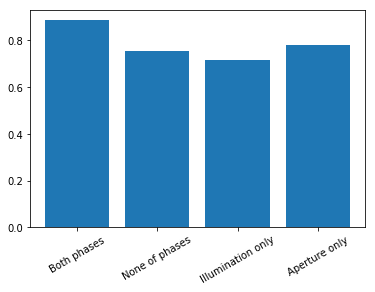

In [39]:
results = [both, neither, illu_only, aper_only]
labels = ['Both phases', 'None of phases', 'Illumination only', 'Aperture only']
x_range = np.arange(len(results))

# Bar plot
plt.bar(x_range, results)
plt.xticks(x_range, labels, rotation=30)
plt.show()

### From the figures, we can clearly see that when both phases are trained, the accuracy is higher than all other cases. It is strange that illumination phase only gives the worst performance, but it makes sense that when aperture phase is trained, the accuracy is higher than when none of the phases is trained.

# 2

## Rerun question 1 with random-phased initialization

In [21]:
# Train both phases
train_illumination = True
train_aperture = True

both_random = get_accuracy(train_illumination, train_aperture, constant_phase=False)

Loss at 0th iteration: 2.3060527
Loss at 100th iteration: 1.6645994
Loss at 200th iteration: 0.6516595
Loss at 300th iteration: 0.7628218
Loss at 400th iteration: 0.54328966
Loss at 500th iteration: 0.6041992
Loss at 600th iteration: 0.22860037
Loss at 700th iteration: 0.2700525
Loss at 800th iteration: 0.23915803
Loss at 900th iteration: 0.09481558
Test accuracy: 0.9175


In [22]:
# Train neither phases
train_illumination = False
train_aperture = False

neither_random = get_accuracy(train_illumination, train_aperture, constant_phase=False)

Loss at 0th iteration: 2.299671
Loss at 100th iteration: 1.3798718
Loss at 200th iteration: 0.6502161
Loss at 300th iteration: 0.6392058
Loss at 400th iteration: 0.512311
Loss at 500th iteration: 0.5373181
Loss at 600th iteration: 0.5623555
Loss at 700th iteration: 0.3308466
Loss at 800th iteration: 0.3954874
Loss at 900th iteration: 0.17543067
Test accuracy: 0.846875


In [23]:
# Train illumination phases
train_illumination = True
train_aperture = False

illu_random = get_accuracy(train_illumination, train_aperture, constant_phase=False)

Loss at 0th iteration: 2.3036773
Loss at 100th iteration: 1.7167301
Loss at 200th iteration: 1.1126689
Loss at 300th iteration: 0.40750518
Loss at 400th iteration: 0.575068
Loss at 500th iteration: 0.49009952
Loss at 600th iteration: 0.3043365
Loss at 700th iteration: 0.13804115
Loss at 800th iteration: 0.1863946
Loss at 900th iteration: 0.12730883
Test accuracy: 0.894375


In [24]:
# Train aperture phases
train_illumination = False
train_aperture = True

aper_random = get_accuracy(train_illumination, train_aperture, constant_phase=False)

Loss at 0th iteration: 2.2989404
Loss at 100th iteration: 1.1589704
Loss at 200th iteration: 0.5262443
Loss at 300th iteration: 0.43089446
Loss at 400th iteration: 0.43918502
Loss at 500th iteration: 0.3555049
Loss at 600th iteration: 0.53851223
Loss at 700th iteration: 0.27219236
Loss at 800th iteration: 0.23987041
Loss at 900th iteration: 0.08475467
Test accuracy: 0.89125


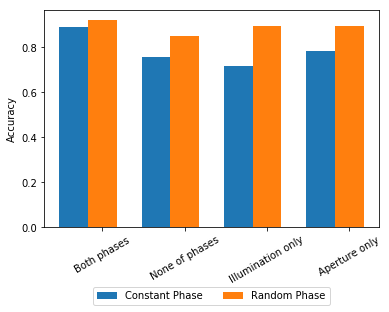

In [40]:
# Display results
results_random = [both_random, neither_random, illu_random, aper_random]

# Bar plot
plt.bar(x_range, results, 0.35, label='Constant Phase')
plt.bar(x_range+0.35, results_random, 0.35, label='Random Phase')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.ylabel('Accuracy')
plt.xticks(x_range+0.35, labels, rotation=30)
plt.show()

### The results from the figure above are reasonable. It is clear that random phases will give better accuracy. The performance with random phase are also proper, with highest accuracy from both trained phases, followed-up by illumination/aperture phase only. And when none of phases are trained, the results are the worst.

## Use random phases for both illumination and aperture, apply different aperture size to observe its effects

In [32]:
# Train both phases
train_illumination = True
train_aperture = True

# Set up the ranges of aperture lens
lens_apert = 8/28
lens_range = np.linspace(0.5, 2, 10)
lens_range = lens_apert/lens_range

# Train and get accuracy for each lens
lens_accu = []
for i in lens_range:
    lens_accu.append(get_accuracy(train_illumination, train_aperture, constant_phase=False, lens_apert=i))

Loss at 0th iteration: 2.3058736
Loss at 100th iteration: 0.8843335
Loss at 200th iteration: 0.4933838
Loss at 300th iteration: 0.42050102
Loss at 400th iteration: 0.40619498
Loss at 500th iteration: 0.37905067
Loss at 600th iteration: 0.20284033
Loss at 700th iteration: 0.08189051
Loss at 800th iteration: 0.20966108
Loss at 900th iteration: 0.12892431
Test accuracy: 0.9271875
Loss at 0th iteration: 2.3006928
Loss at 100th iteration: 1.288671
Loss at 200th iteration: 0.43821588
Loss at 300th iteration: 0.518018
Loss at 400th iteration: 0.48520285
Loss at 500th iteration: 0.6069714
Loss at 600th iteration: 0.46933508
Loss at 700th iteration: 0.19418153
Loss at 800th iteration: 0.1846925
Loss at 900th iteration: 0.12240837
Test accuracy: 0.9175
Loss at 0th iteration: 2.3038998
Loss at 100th iteration: 1.5122278
Loss at 200th iteration: 0.54769284
Loss at 300th iteration: 0.62156427
Loss at 400th iteration: 0.46100515
Loss at 500th iteration: 0.36992708
Loss at 600th iteration: 0.39678082

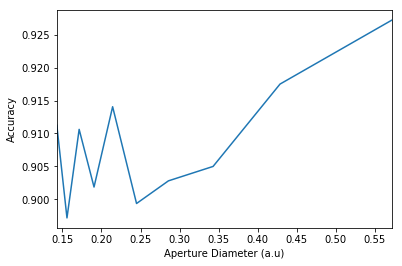

In [35]:
# Display results
plt.plot(lens_range, lens_accu)
plt.xlabel('Aperture Diameter (a.u)')
plt.ylabel('Accuracy')
plt.xlim([lens_range.min(), lens_range.max()])
plt.show()

### This result from varied aperture size is interesting. Before 0.35, there is no significant difference in performance among different aperture size. However, with larger the aperture diameter with less signals filtered out, the performance of the model goes up almost linearly.